In [ ]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as mcolors

plt.style.use('matplotlib.mplstyle')

DATA_DIR = 'Data/'
data_name = 'summary.txt'

col_names = ['Step','t','M','LogL','LogR',
             'LogTs','LogTc','Logrhoc','logPc','psic',
             'Xc','Yc','XCc','XNc','XOc',
             'taudyn','tauKH','taunuc','Lpp','LCNO',
             'L3a','LZ','Lv','MHe','MC',
             'MO','RHe','RC','RO']

col_names_structure = ['Mr','r','Lr','P','rho',
                       'T','U','S','Cp','adia1',
                       'nablaad','mu','ne','Pe','Pr',
                       'nablarad','nabla','vc','kappa','epsnuc',
                       'epspp','epscno','eps3alpha','epsvnuc','epsv', 'epsgrav',
                       'X','-','X+','Y', 'Y+', 'Y++', 'XC', 'XN', 'XO', 'Psi']

masses = np.array([0.1, 0.5, 1, 1.5, 2,
                   3, 5, 8, 10, 15,
                   20, 30, 50, 100])

metallicities = np.array([0.0001,0.0003,0.001,0.004,0.01,0.02,0.03])

In [63]:
# Function that adds both P_ion to existing structure file df 

def P_ion(df):
    # Constants
    k = 1.380649e-23 # Boltzmann [J/K]
    m_u = 1.6605e-27 # Atomic mass unit [kg]

    P_ion1 = df['rho']*k*df['T'] / (df['mu']*m_u) # Eq 5
    P_ion2 = df['P'] - df['Pe'] - df['Pr']

    df['Pion1'] = P_ion1
    df['Pion2'] = P_ion2
    
    return df

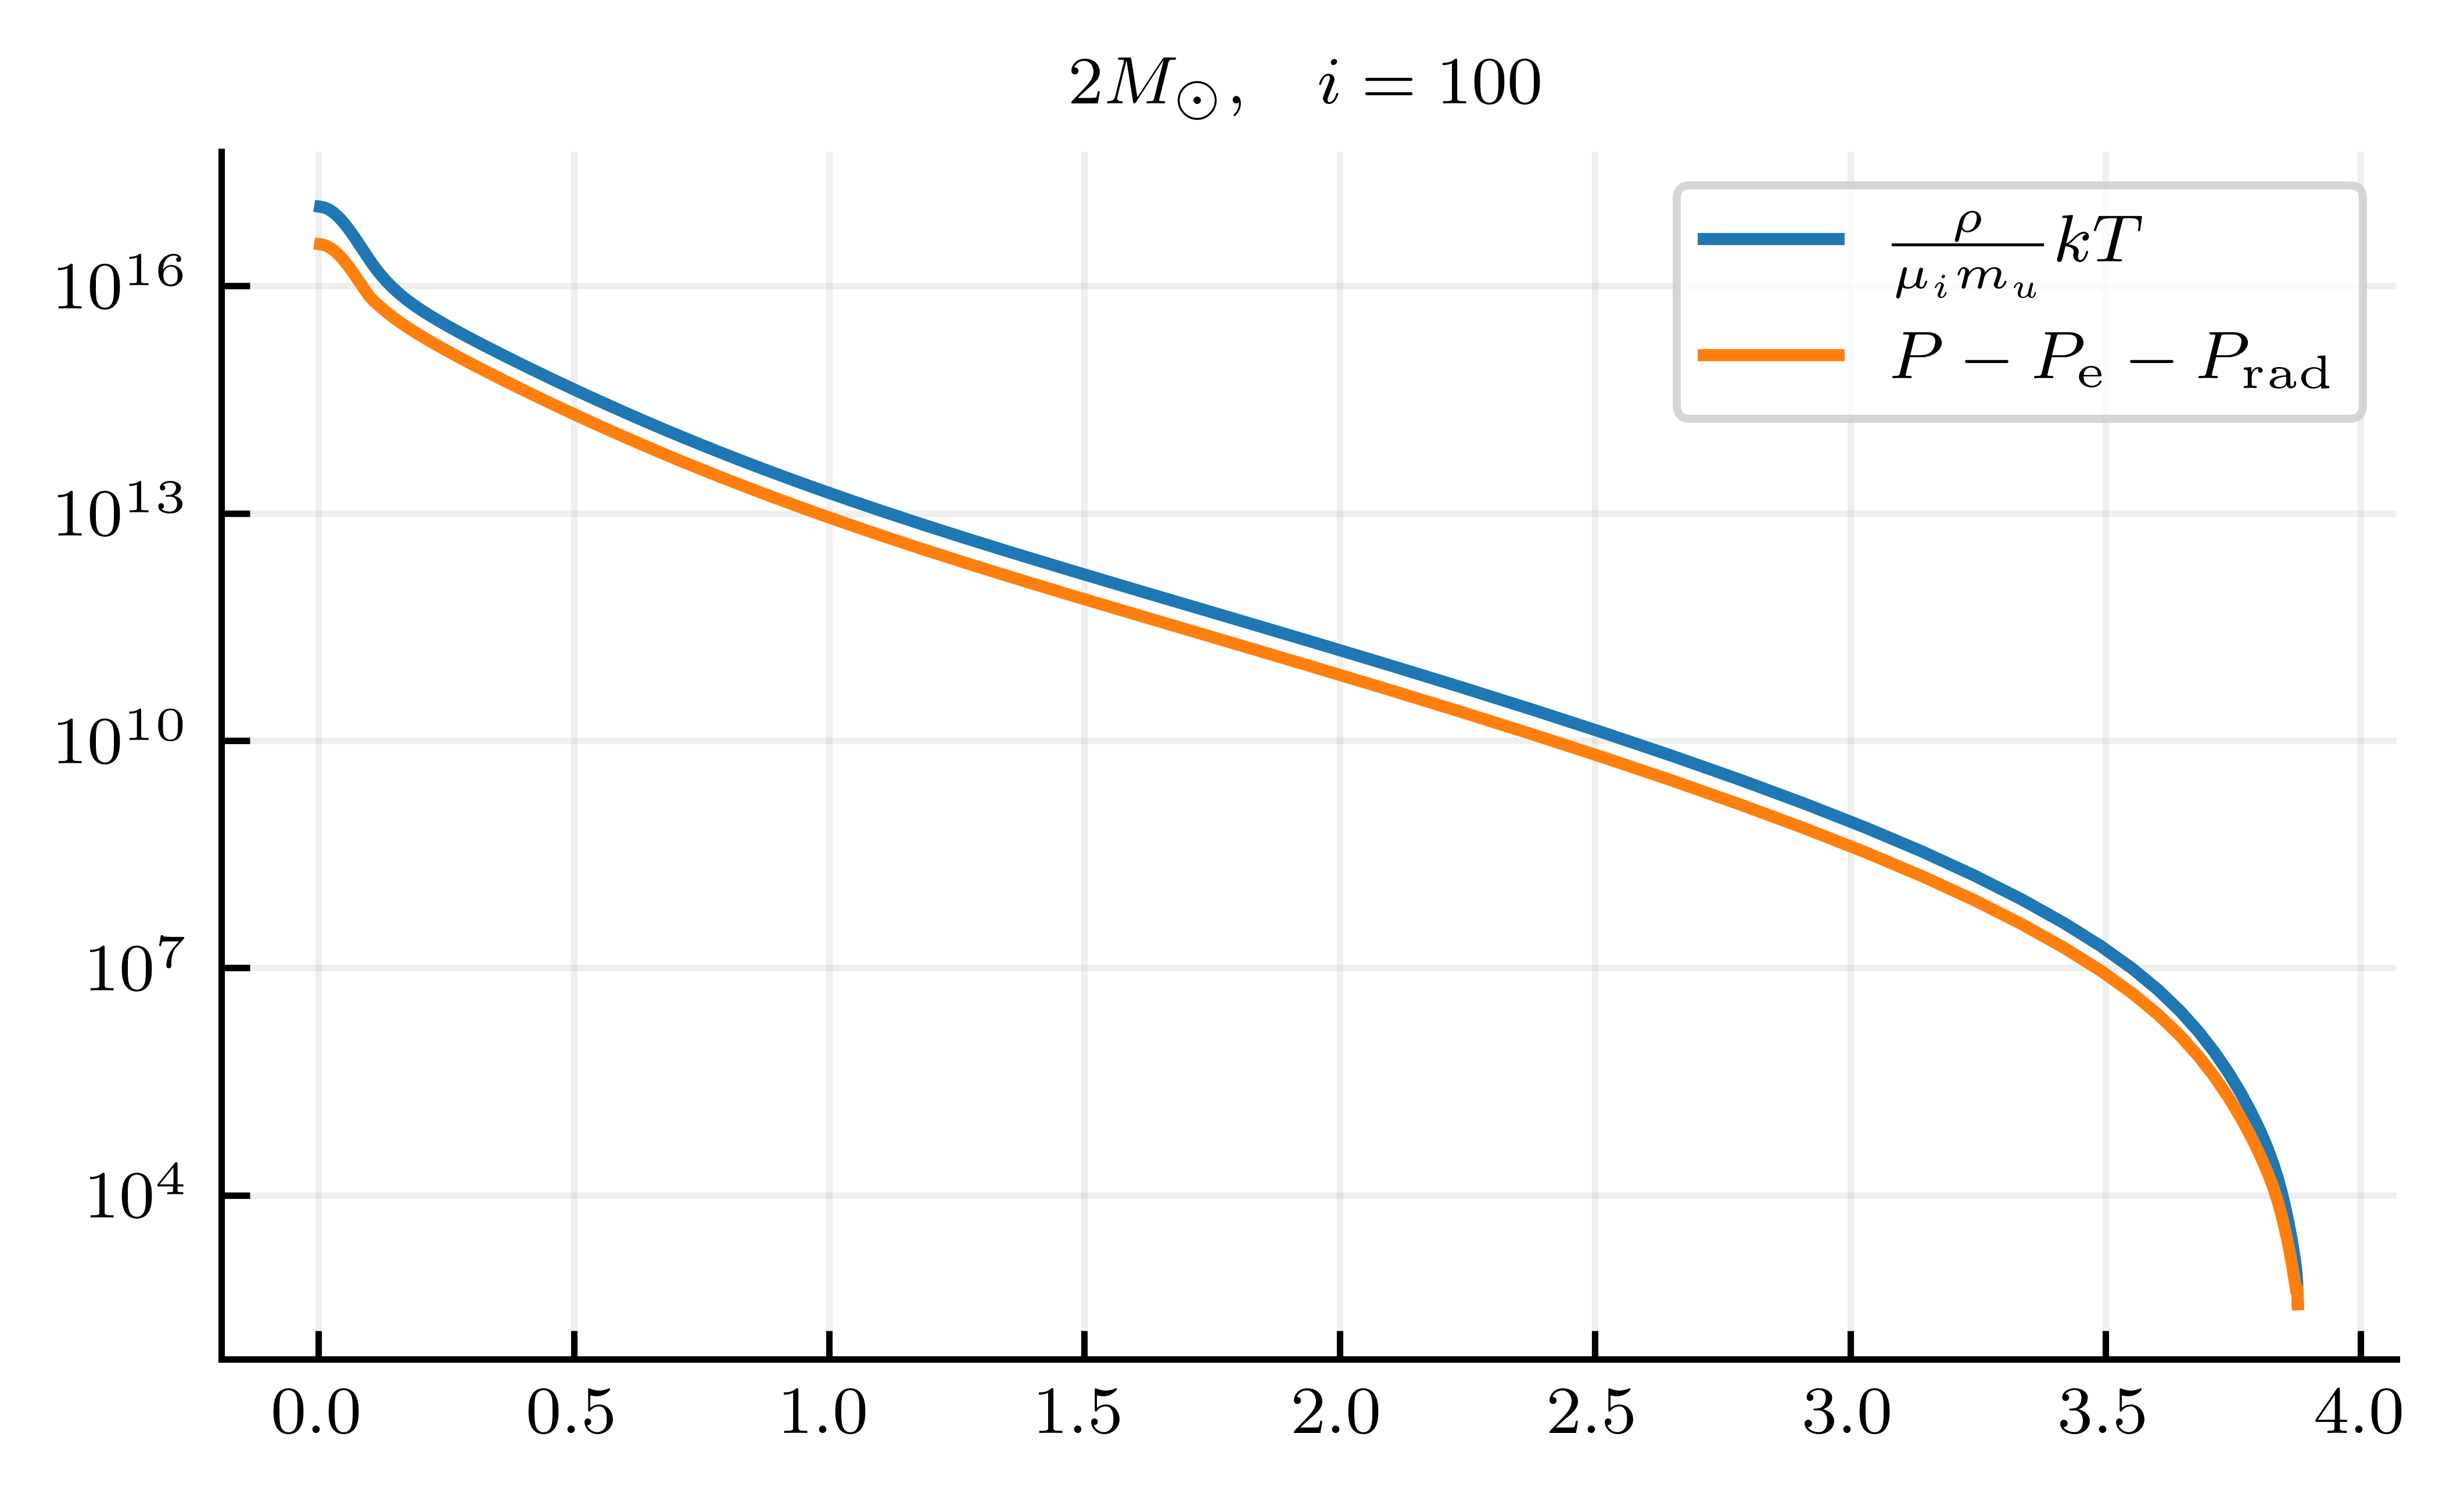

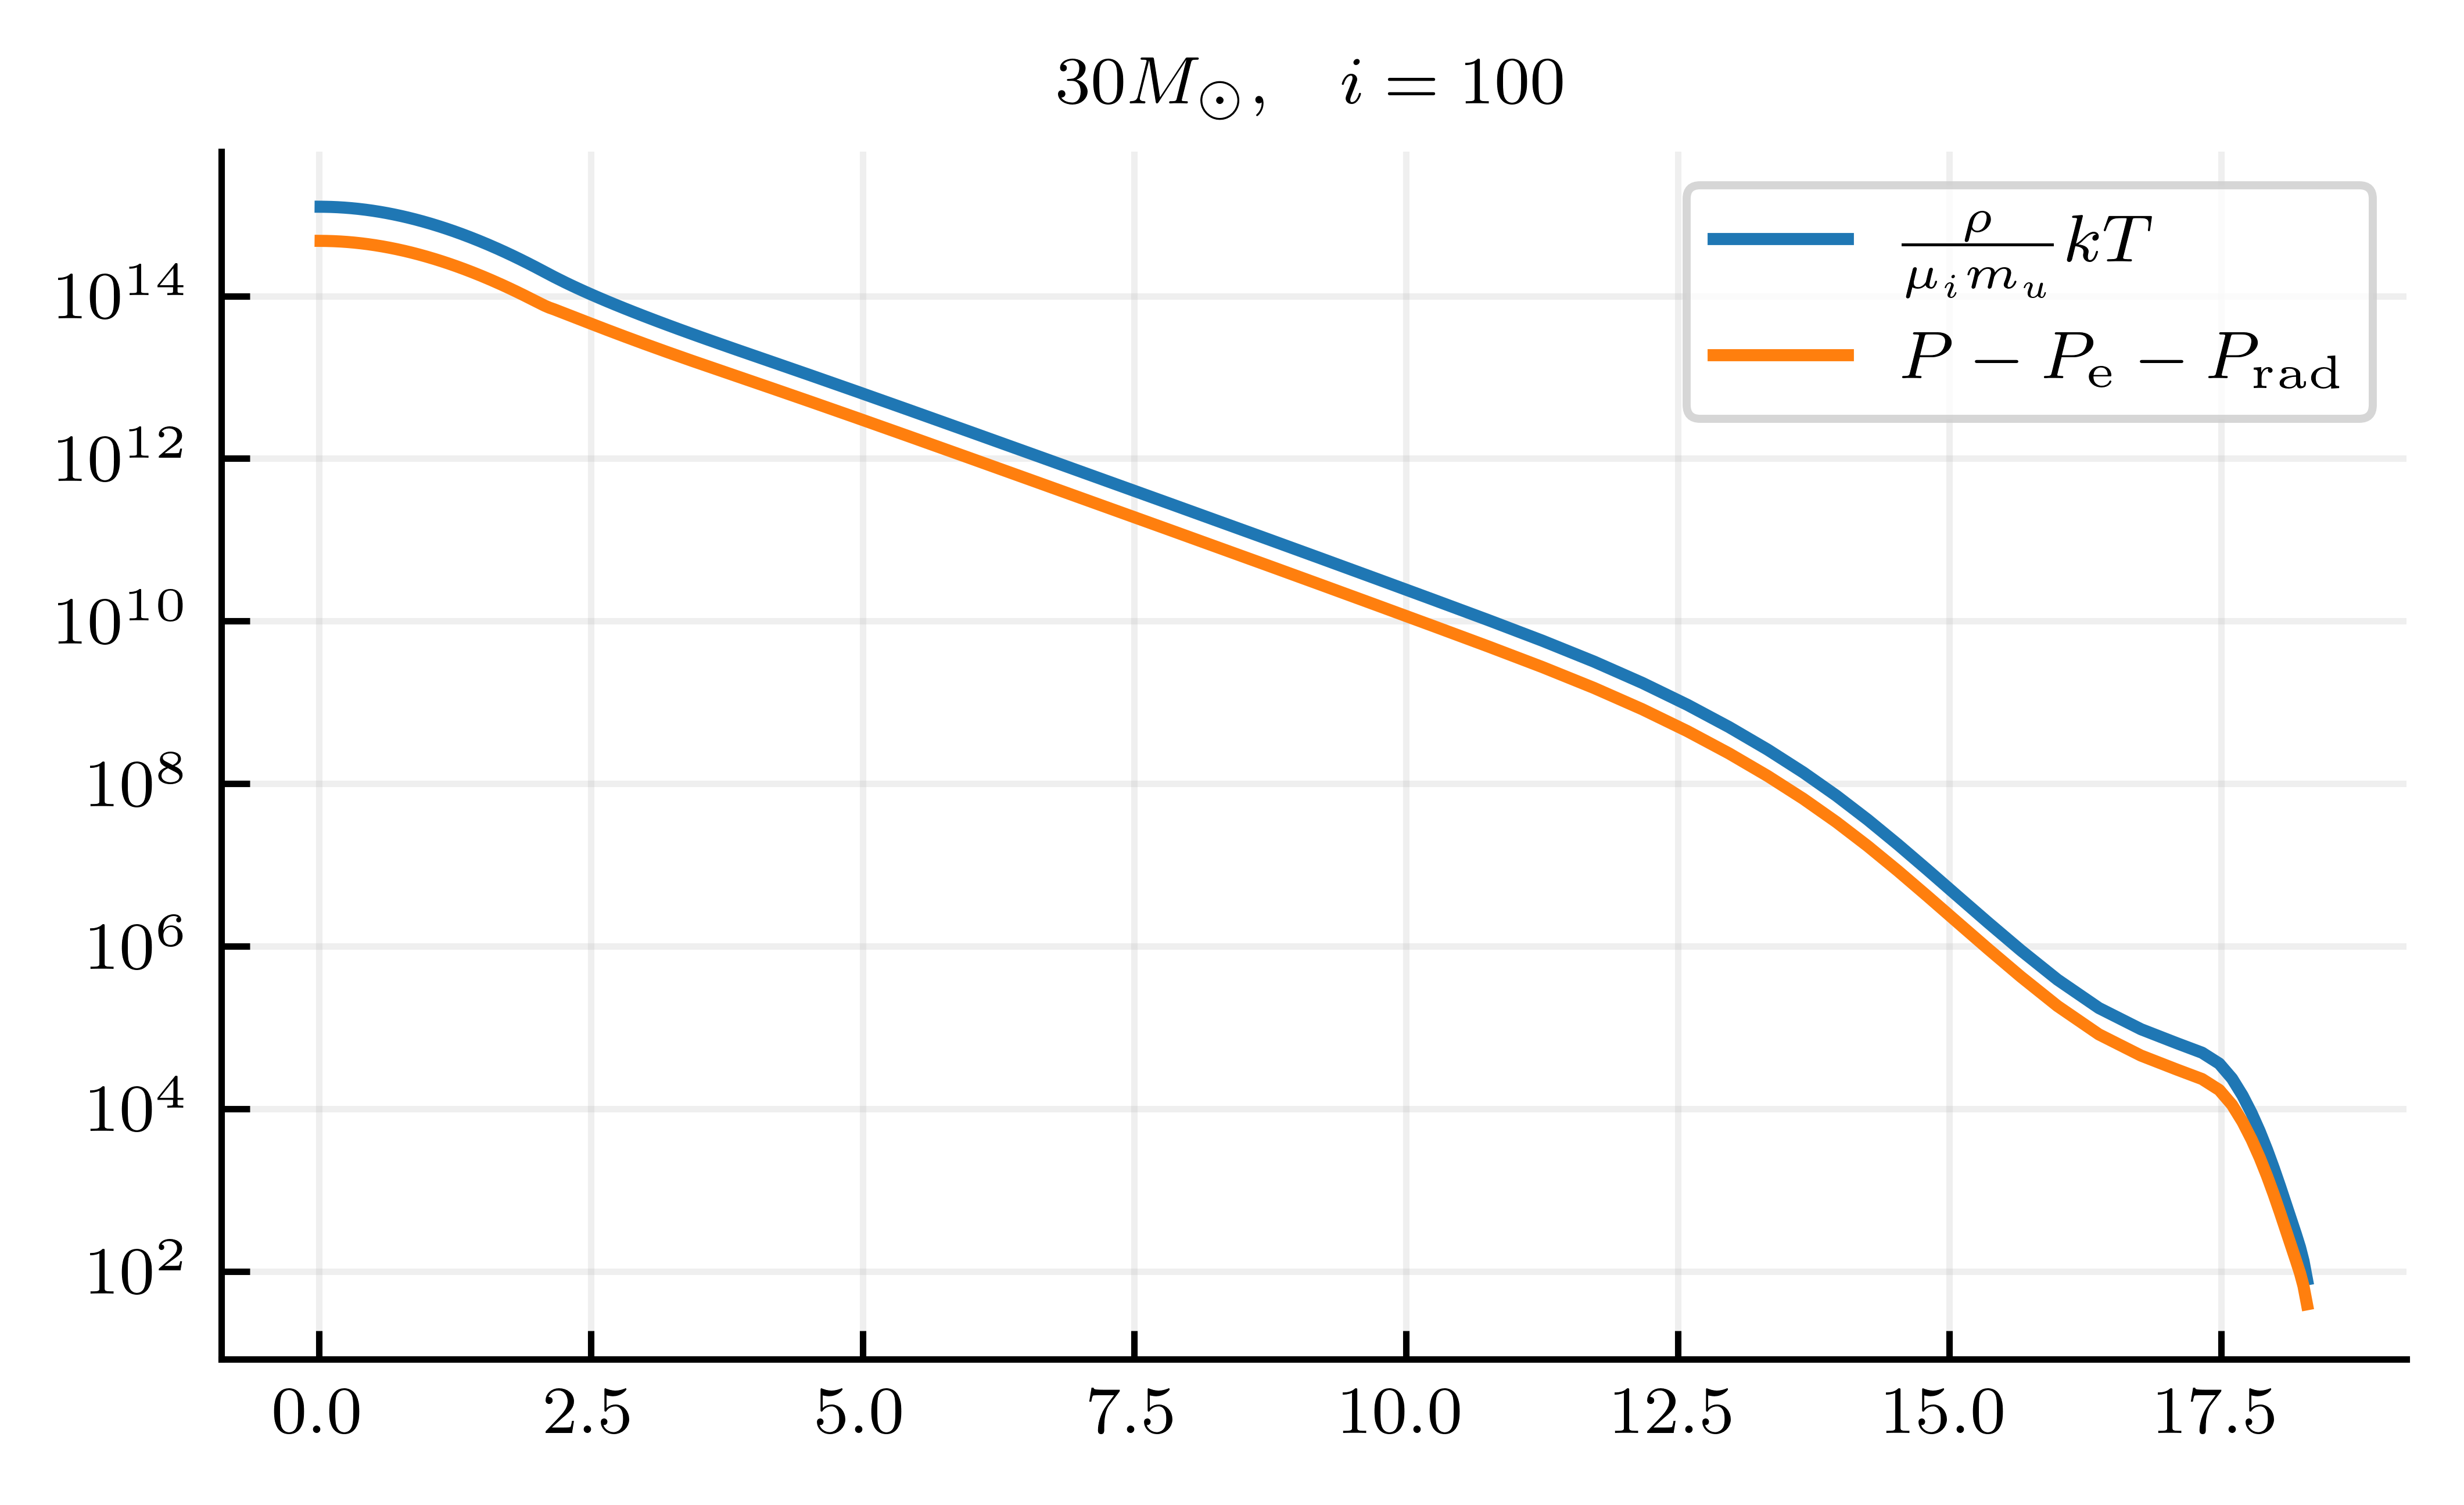

In [84]:
# To-do:
#   - Find "important" times t to investigate (and convert to Step)
#   - Helium, carbon and oxygen core radii could be included

def plot_Pion(masses,metallicities,step=1):
    for i,mass in enumerate(masses):
        fig,ax = plt.subplots() # One plot per mass
        
        for j,metal in enumerate(metallicities):
            # Import data and calculate both P_ion
            df = pd.read_csv(DATA_DIR+f'/{mass:.3g}M_{metal:.3g}'+f'/structure_{step:05d}.txt',
                                delim_whitespace=True, header=None)
            df.columns = col_names_structure
            df = P_ion(df)

            # Plotting
            ax.semilogy(df['r'],df['Pion1'],label=r'$\frac{\rho}{\mu_i m_u}kT$')
            ax.semilogy(df['r'],df['Pion2'],label=r'$P-P_{\mathrm{e}}-P_{\mathrm{rad}}$')
            ax.set_title(f'{mass:.3g}'+r'$M_\odot$,'+rf'$\quad i={step}$')

        ax.legend()
        ax.grid(which='both', alpha=0.2, visible=True)

mass = [2,30] # M_sun
metal = [0.02]
step = 100 # Which structure file to analyze

plot_Pion(mass,metal,step)